# HW Project

This project uses data from https://www.kaggle.com/datasets/thedevastator/airlines-traffic-passenger-statistics?resource=download

This dataset was found on Kaggle.

In [1]:
!pip install xgboost
!pip install statsmodels

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import statsmodels.api

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb

## Loading the data about the air traffic passengers statics.

In [3]:
df = pd.read_csv('air_traffic.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15007 entries, 0 to 15006
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   index                        15007 non-null  int64 
 1   Activity Period              15007 non-null  int64 
 2   Operating Airline            15007 non-null  object
 3   Operating Airline IATA Code  14953 non-null  object
 4   Published Airline            15007 non-null  object
 5   Published Airline IATA Code  14953 non-null  object
 6   GEO Summary                  15007 non-null  object
 7   GEO Region                   15007 non-null  object
 8   Activity Type Code           15007 non-null  object
 9   Price Category Code          15007 non-null  object
 10  Terminal                     15007 non-null  object
 11  Boarding Area                15007 non-null  object
 12  Passenger Count              15007 non-null  int64 
 13  Adjusted Activity Type Code  15

We will use only Operating Airline, GEO Summary, GEO Region, and Passenger Count. 

In [4]:
month_dict = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['Month'] = df['Month'].map(month_dict)

In [6]:
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
df.set_index('date', inplace=True)

df = df[['Operating Airline', 'Passenger Count', 'GEO Summary', 'GEO Region']]

In [7]:
df.head()

,Operating Airline,Passenger Count,GEO Summary,GEO Region
date,,,,
2005-07-01,ATA Airlines,27271,Domestic,US
2005-07-01,ATA Airlines,29131,Domestic,US
2005-07-01,ATA Airlines,5415,Domestic,US
2005-07-01,Air Canada,35156,International,Canada
2005-07-01,Air Canada,34090,International,Canada


In [8]:
df.tail()

,Operating Airline,Passenger Count,GEO Summary,GEO Region
date,,,,
2016-03-01,Virgin America,194636,Domestic,US
2016-03-01,Virgin America,4189,International,Mexico
2016-03-01,Virgin America,4693,International,Mexico
2016-03-01,Virgin Atlantic,12313,International,Europe
2016-03-01,Virgin Atlantic,10898,International,Europe


## Splitting the data on test and train

Groupping the data by Operating Airline, type of flight (international or domestic and GEO Region of flight.

In [9]:
df_grouped = df.groupby(['date', 'Operating Airline', 'GEO Summary', 'GEO Region'])['Passenger Count'].sum()

df_grouped = df_grouped.reset_index()

df_grouped.set_index('date', inplace=True)
df_grouped.head()

,Operating Airline,GEO Summary,GEO Region,Passenger Count
date,,,,
2005-07-01,ATA Airlines,Domestic,US,61817
2005-07-01,Air Canada,International,Canada,69246
2005-07-01,Air China,International,Asia,11763
2005-07-01,Air France,International,Europe,23688
2005-07-01,Air New Zealand,International,Australia / Oceania,9960


In [10]:
X = df_grouped[['Operating Airline', 'GEO Summary', 'GEO Region']]
y = df_grouped['Passenger Count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    shuffle=False
)

## Visualizing data using Seaborn library

Visualizing groupped data.

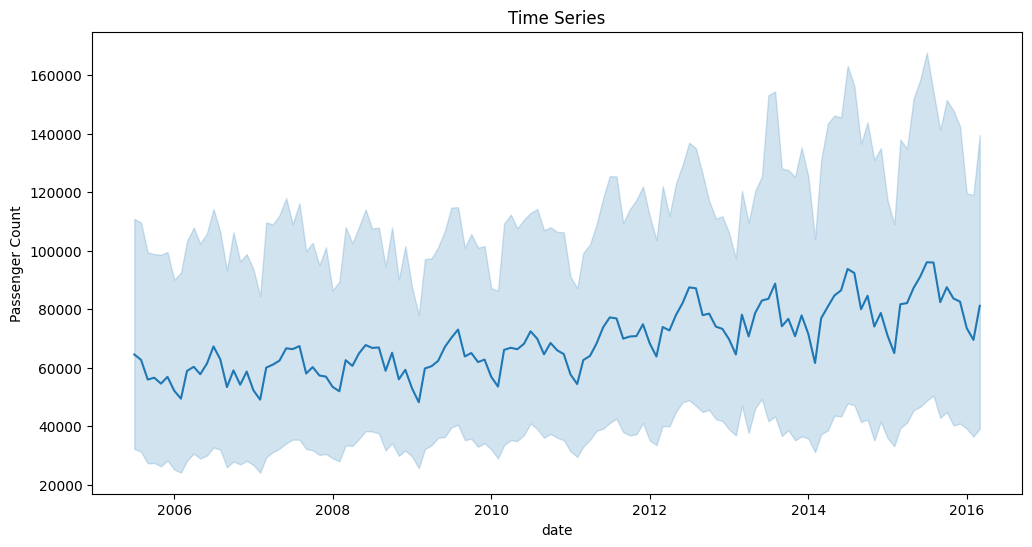

/opt/anaconda3/envs/ml_projects/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0.5, 1.0, 'Seasonality')

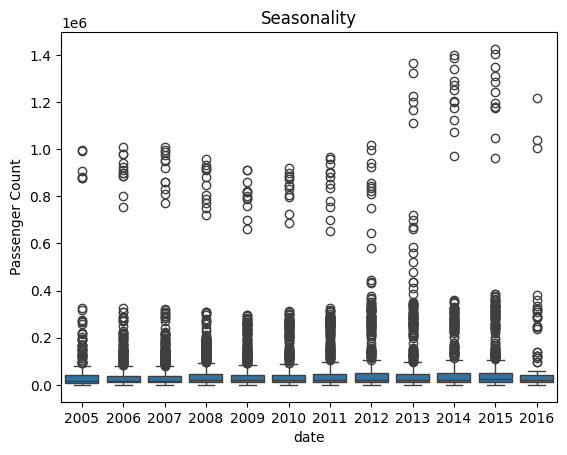

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped['Passenger Count'])
plt.title('Time Series')
plt.show()

sns.boxplot(x=df_grouped.index.year, y=df_grouped['Passenger Count'])
plt.title('Seasonality')

## Decompose the time series into three components.

Before decomposing we will group the data by date to analyze general trend.

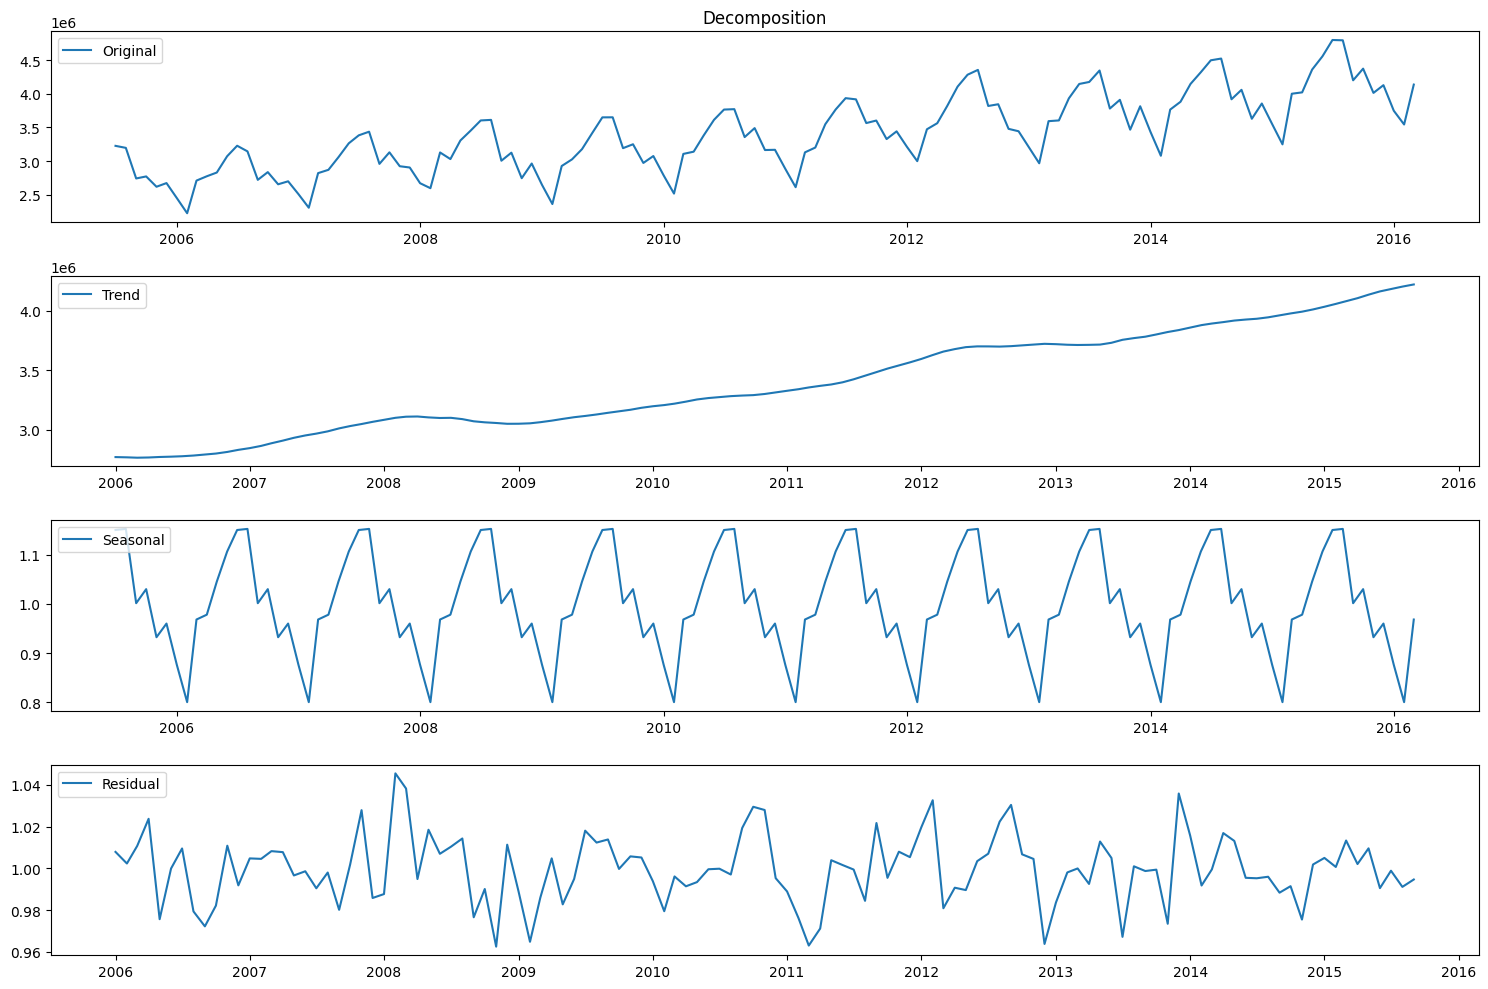


Statistics:
Mean: 1.00
Mean Squared Deviation: 0.02


In [12]:
monthly_passengers = df_grouped.groupby('date')['Passenger Count'].sum()

decomposition = seasonal_decompose(monthly_passengers, period=12, model='multiplicative')

plt.figure(figsize=(15, 10))

plt.subplot(411)
plt.plot(monthly_passengers, label='Original')
plt.legend(loc='upper left')
plt.title('Decomposition')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("\nStatistics:")
print(f"Mean: {decomposition.seasonal.mean():.2f}")
print(f"Mean Squared Deviation: {decomposition.resid.std():.2f}")

## Creating features

We will create such features:


Data about previous months:

- lag_1: quantity of passengers last month 
- lag_2: quantity of passengers two month before current
- lag_3: quantity of passengers two month before current

Rolling means during previous months: 

- rolling_mean_3: mean quantity of passengers during past 3 months
- rolling_mean_6: mean quantity of passengers during past 6 months
- rolling_mean_12: mean quantity of passengers during past year

Time data: 
- month
- year
- quarter
- season

In [13]:
def create_features(df):
    df = df.copy()
    
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    
    df['lag_1'] = df['Passenger Count'].shift(1)
    df['lag_2'] = df['Passenger Count'].shift(2)
    df['lag_3'] = df['Passenger Count'].shift(3)
    
    df['rolling_mean_3'] = df['Passenger Count'].rolling(window=3).mean()
    df['rolling_mean_6'] = df['Passenger Count'].rolling(window=6).mean()
    df['rolling_mean_12'] = df['Passenger Count'].rolling(window=12).mean()
    
    df['season'] = np.where(df.index.month.isin([12, 1, 2]), 'Winter',
                  np.where(df.index.month.isin([3, 4, 5]), 'Spring',
                  np.where(df.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))
    
    df = pd.get_dummies(df, columns=['season'])
    
    return df

In [14]:
df_features = create_features(monthly_passengers.to_frame())

df_features = df_features.dropna()

feature_columns = ['month', 'quarter', 'year', 
                  'lag_1', 'lag_2', 'lag_3',
                  'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12',
                  'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']

Splitting the data

In [15]:
X = df_features.drop('Passenger Count', axis=1)
y = df_features['Passenger Count']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)


Creating and training RandomForest

In [17]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42
)

In [18]:
rf_model.fit(X_train, y_train)

train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)


Metrics:
MAE: 248310.62
RMSE: 288096.70
R^2: 0.54


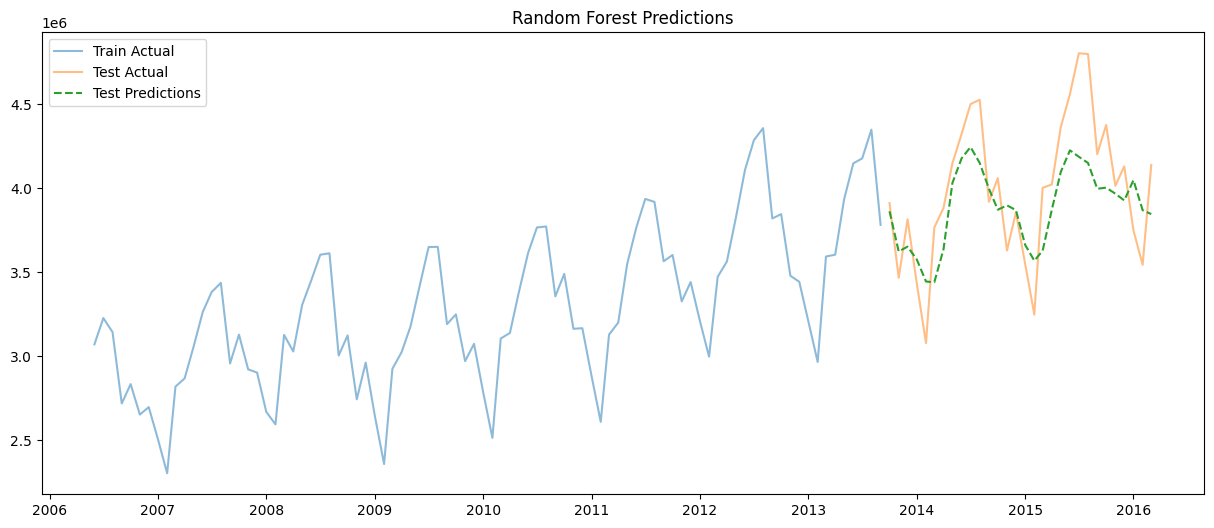

In [19]:
print("Metrics:")
print(f"MAE: {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.2f}")
print(f"R^2: {r2_score(y_test, test_pred):.2f}")

plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Train Actual', alpha=0.5)
plt.plot(y_test.index, y_test, label='Test Actual', alpha=0.5)
plt.plot(y_test.index, test_pred, label='Test Predictions', linestyle='--')
plt.title('Random Forest Predictions')
plt.legend()
plt.show()


In [20]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
print("Top 10 important features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

Top 10 important features:
            feature  importance
6    rolling_mean_3    0.815386
0             month    0.051693
3             lag_1    0.028714
4             lag_2    0.022330
5             lag_3    0.020945
8   rolling_mean_12    0.013193
7    rolling_mean_6    0.011666
12    season_Winter    0.008398
10    season_Spring    0.008163
9       season_Fall    0.006143


## ETS Class model

Now we are going to make forecasts using model of ETS class.

In [21]:
monthly_total = df_grouped.groupby('date')['Passenger Count'].sum()

train_size = int(len(monthly_total) * 0.75)
train = monthly_total[:train_size]
test = monthly_total[train_size:]

In [22]:
ets_model = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend='add',
    seasonal='mul',
    damped_trend=True
)

/opt/anaconda3/envs/ml_projects/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [23]:
ets_fit = ets_model.fit(optimized=True)

forecast = ets_fit.forecast(len(test))

/opt/anaconda3/envs/ml_projects/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Metrics:
MAE: 165364.45
RMSE: 196443.09
R2: 0.77


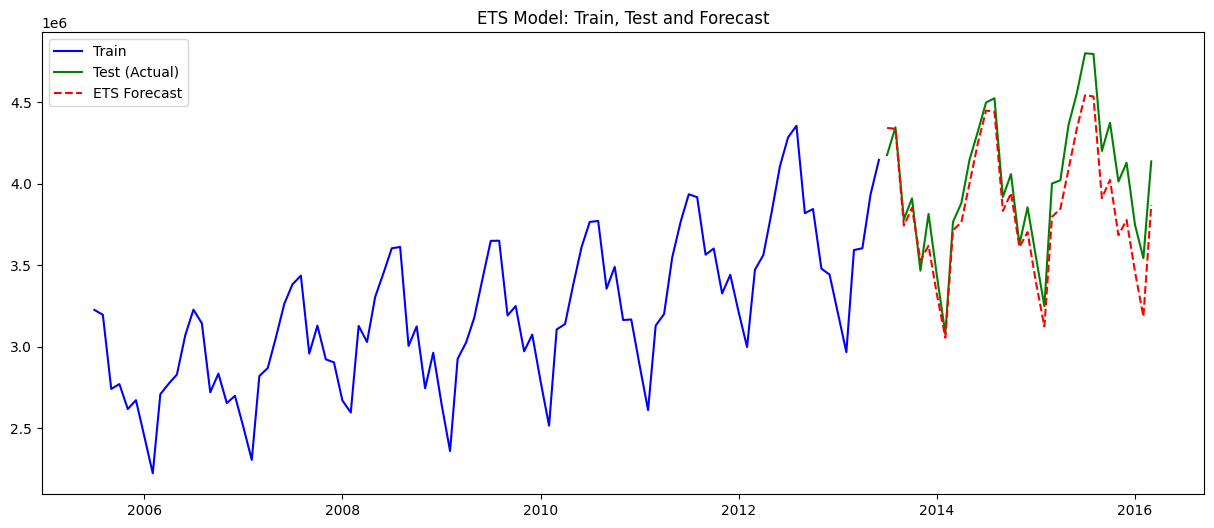

In [24]:
print("Metrics:")
print(f"MAE: {mean_absolute_error(test, forecast):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test, forecast)):.2f}")
print(f"R2: {r2_score(test, forecast):.2f}")

plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Actual)', color='green')
plt.plot(test.index, forecast, label='ETS Forecast', color='red', linestyle='--')
plt.title('ETS Model: Train, Test and Forecast')
plt.legend()
plt.show()

## Surprise part 

Let's use XGBoost library to train gradient boosting.

In [25]:
X = df_features.drop('Passenger Count', axis=1)
y = df_features['Passenger Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

Training XGBoosting

In [26]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

In [27]:
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

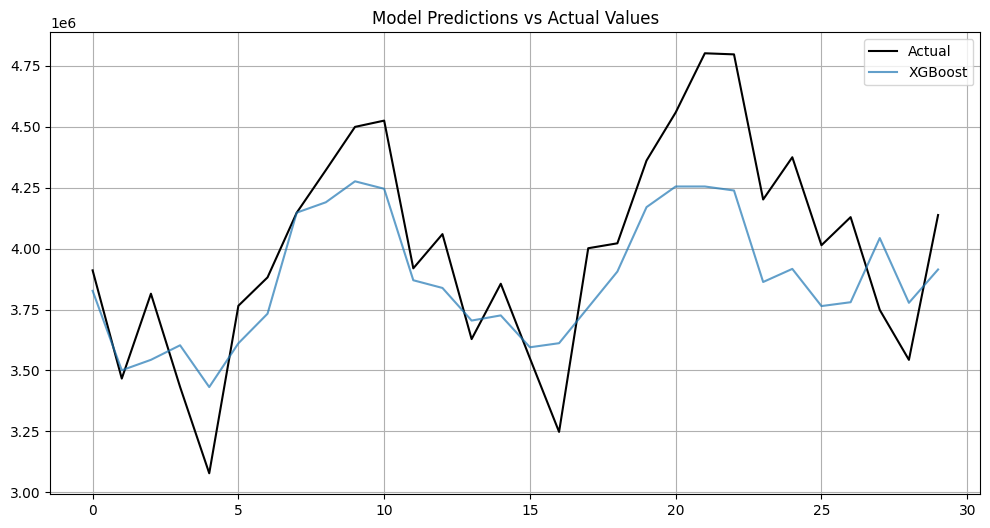

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual', color='black')
plt.plot(range(len(xgb_pred)), xgb_pred, label='XGBoost', alpha=0.7)
plt.title('Model Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print("Metrics:")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}")
print(f"R2: {r2_score(y_test, xgb_pred):.2f}")

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
print("\nTop 10 important features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

Metrics:
MAE: 228034.48
RMSE: 267496.27
R2: 0.60

Top 10 important features:
            feature  importance
6    rolling_mean_3    0.581903
10    season_Spring    0.185874
0             month    0.048178
4             lag_2    0.036210
9       season_Fall    0.034456
5             lag_3    0.028441
11    season_Summer    0.026286
8   rolling_mean_12    0.019089
12    season_Winter    0.014005
2              year    0.010962


So we trained 3 models: 

- RandomForest with R^2 - 0.54, MAE - 248310.62, RMSE - 288096.70
- ETS with R^2 - 0.77, MAE - 165364.45, RMSE - 196443.09
- XGBoost with R^2 - 0.6, MAE - 228034.48, RMSE - 267496.27

The Best results are shown by ETS model it is working much better than XGBoosting and RandomForests.